<a href="https://colab.research.google.com/github/ChitraChaudhari/Traffic-Sign-Classifier/blob/master/Traffic_sign_classifier_using_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [0]:
with open("german-traffic-signs/train.p","rb") as f:
  train_data = pickle.load(f)
with open("german-traffic-signs/valid.p","rb") as f:
  valid_data = pickle.load(f)
with open("german-traffic-signs/test.p","rb") as f:
  test_data = pickle.load(f)

x_train, y_train = train_data["features"],train_data["labels"]
x_valid, y_valid = valid_data["features"],valid_data["labels"]
x_test, y_test = test_data["features"],test_data["labels"]

In [0]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert (x_train.shape[0] == y_train.shape[0]),"The number of train images are not equal to number of labels"
assert (x_valid.shape[0] == y_valid.shape[0]),"The number of valid images are not equal to number of labels"
assert (x_test.shape[0] == y_test.shape[0]),"The number of test images are not equal to number of labels"
assert (x_train.shape[1:]== (32,32,3)),"The dimentions of train images are not 32X32X3"
assert (x_valid.shape[1:]== (32,32,3)),"The dimentions of valid images are not 32X32X3"
assert (x_test.shape[1:]== (32,32,3)),"The dimentions of test images are not 32X32X3"

In [0]:
data = pd.read_csv("german-traffic-signs/signnames.csv")
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

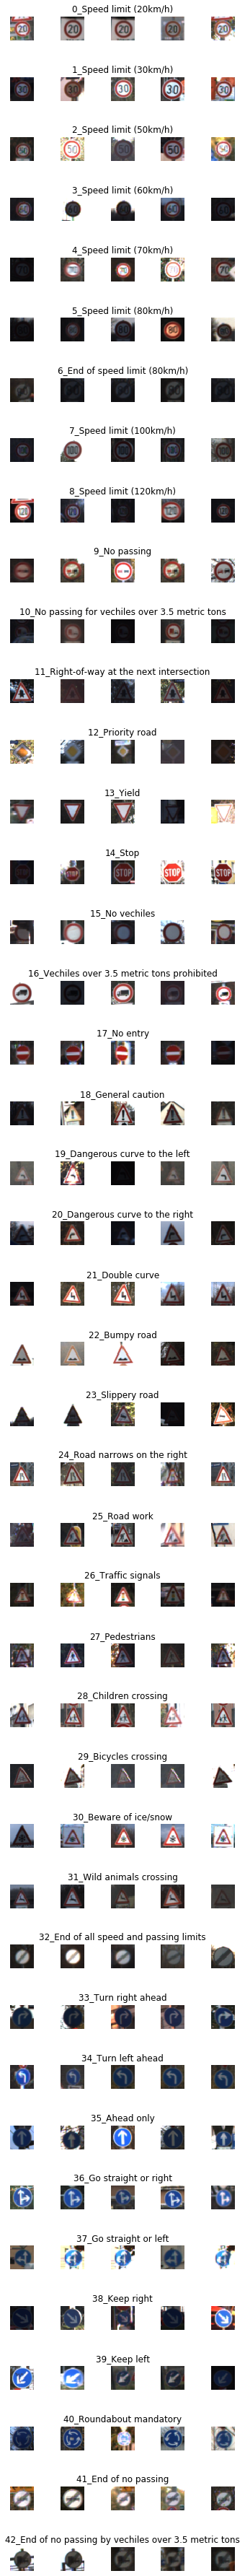

In [0]:
num_of_samples = []
     
cols = 5
num_classes = 43
     
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

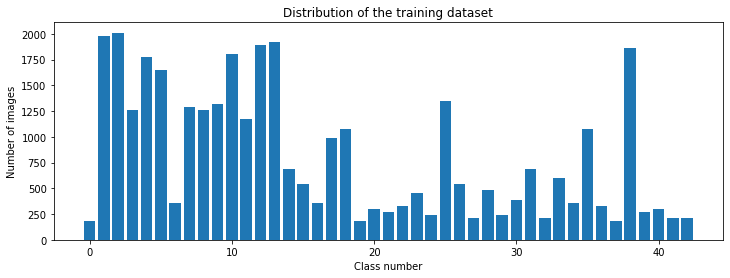

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)


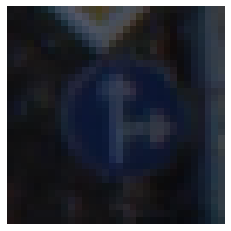

In [0]:
#Preprocessing image
import cv2

plt.imshow(x_train[1000])
plt.axis("off")
print(x_train[1000].shape)

(32, 32)


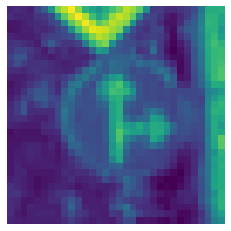

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(x_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


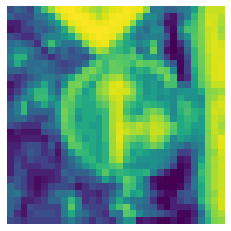

In [0]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)



In [0]:
def preprocessing(img):
  grayscal_img = grayscale(img)
  equalize_img = equalize(grayscal_img)
  normalized_img = equalize_img/255
  return normalized_img

x_train = np.array(list(map(preprocessing,x_train)))
x_valid = np.array(list(map(preprocessing,x_valid)))
x_test = np.array(list(map(preprocessing,x_test)))

(34799, 32, 32)


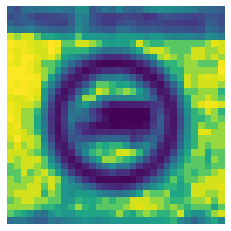

In [0]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)])
plt.axis("off")
print(x_train.shape)

In [0]:
x_train = x_train.reshape(34799,32,32,1)
x_test = x_test.reshape(12630,32,32,1)
x_valid = x_valid.reshape(4410,32,32,1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              zoom_range = 0.2,
                              shear_range = 0.1,
                              rotation_range = 10)

datagen.fit(x_train)

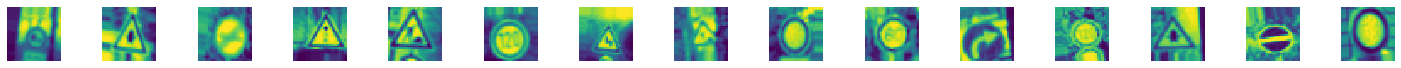

In [0]:
batches = datagen.flow(x_train,y_train,batch_size=20)
x_batch, y_batch = next(batches)

fig, axs = plt.subplots(1,15,figsize = (20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32,32))
  axs[i].axis('off')

In [0]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_valid = to_categorical(y_valid,43)

In [0]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape= (32,32,1),activation="relu"))
  model.add(Conv2D(60,(5,5),activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30,(3,3),activation="relu"))
  model.add(Conv2D(30,(3,3),activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500,activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation="softmax"))
  model.compile(Adam(lr =0.001), loss = "categorical_crossentropy", metrics = ['accuracy'])
  return model

In [0]:
model = leNet_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

In [0]:
#history = model.fit(x_train,y_train,epochs=15,validation_data= (x_valid,y_valid),batch_size=400,verbose=1,shuffle=1)
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=50),steps_per_epoch=2000,epochs=10,validation_data=(x_valid,y_valid),shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.9039 - acc: 0.7347 - val_loss: 0.1610 - val_acc: 0.9546
Epoch 2/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.2207 - acc: 0.9316 - val_loss: 0.0556 - val_acc: 0.9848
Epoch 3/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.1496 - acc: 0.9532 - val_loss: 0.0632 - val_acc: 0.9864
Epoch 4/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.1139 - acc: 0.9649 - val_loss: 0.0518 - val_acc: 0.9891
Epoch 5/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.0977 - acc: 0.9701 - val_loss: 0.0447 - val_acc: 0.9889
Epoch 6/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.0866 - acc: 0.9732 - val_loss: 0.0423 - val_acc: 0.9880
Epoch 7/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0770 - acc: 0.9768 - val_loss: 0.0484 - val_acc: 0.9868
Epoch 8/10
2000/2000 [==========================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

Text(0.5, 0, 'epoch')

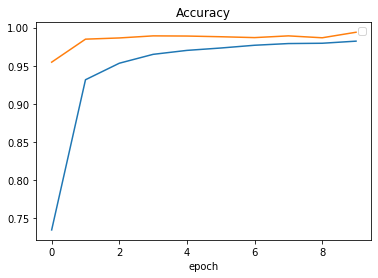

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend('training','validation')
plt.title("Accuracy")
plt.xlabel('epoch')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

Text(0.5, 0, 'epoch')

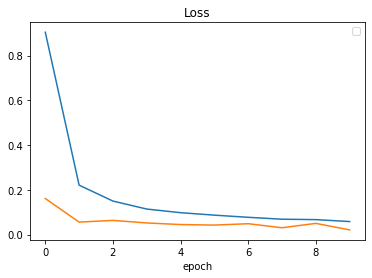

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('training','validation')
plt.title("Loss")
plt.xlabel('epoch')

In [0]:
score = model.evaluate(x_test,y_test,verbose=0)
print(score)

[0.13940838885980508, 0.9711005542548233]


     https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

    https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

    https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

    https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

    https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg




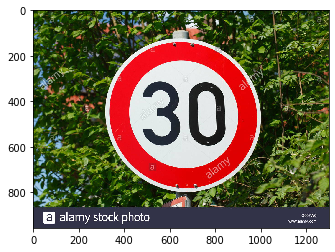

In [0]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
predicted sign: [1]


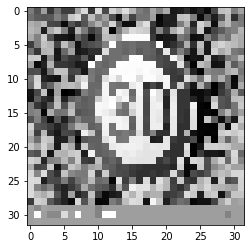

In [0]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))